In [1]:
import sys
sys.path.insert(1, '../')


In [2]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/home/llja/repos/Uni_ACS/mimiciv_sepsis_mortality/../medical_explainer.py'>

In [3]:
import pandas as pd
data = pd.read_csv('mimiciv_sepsis.csv').drop(['testtrain', 'hadm_id'], axis=1)

data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

data = pd.concat([data, pd.get_dummies(data['marital_status'], prefix='marital_status')], axis=1)
data = data.drop(['marital_status'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ethnicity'], prefix='ethnicity')], axis=1)
data = data.drop(['ethnicity'], axis=1)

data = pd.concat([data, pd.get_dummies(data['insurance'], prefix='insurance')], axis=1)
data = data.drop(['insurance'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ed_medgp_antibiotic_hrgp'], prefix='antibiotic')], axis=1)
data = data.drop(['ed_medgp_antibiotic_hrgp'], axis=1)


In [4]:
from sklearn.model_selection import train_test_split

seed = 7

X = data.drop(['icu_adm_flag', 'hosdeath_flag'], axis=1)
y = data['hosdeath_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)


In [5]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

estimators = [('Scaler', StandardScaler()), ('Log_Reg', LogisticRegression(random_state=seed, solver='liblinear'))]
pipe = Pipeline(estimators)

clf = pipe.fit(X_train, y_train)


| Step 1  ==> Calibrating model


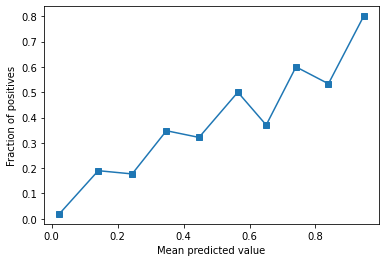

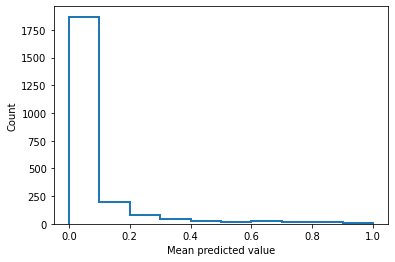

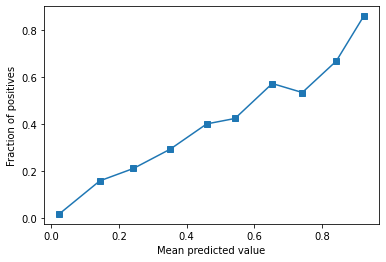

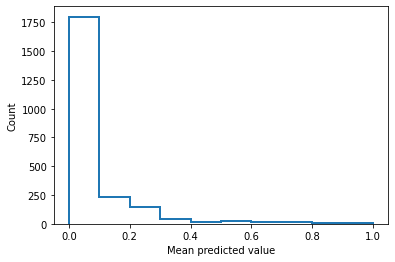

ROC AUC: 0.8820026662716635
Average Precision: 0.4157228149040318
Accuracy: 0.9332466406588643
ROC AUC: 0.8821522737372243
Average Precision: 0.4149705085801185
Accuracy: 0.9349804941482445

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 54.0

Probability threshold: 0.5
Score threshold: 76.0

Probability threshold: 0.9
Score threshold: 80.0



In [17]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='linear', method='novel')

In [20]:
explainer.shap_array_list

[[0.7127235908270718, -0.7807780691856866],
 [-0.5593667576216323, 0.6129606262494817],
 [-0.525301385171693, 0.5175385666859451],
 [-0.3845133758944053, 0.3446902530461044],
 [0.34233030923137564, -0.33754773092609824],
 [-0.1940507437794423, 0.43220071112203895],
 [-0.26818521114119376, 0.252264226022867],
 [-0.23886547928718013, 0.2320772680913676],
 [-0.1864439665462134, 0.29580344571034606],
 [-0.10144212911735465, 0.912979162056192]]

In [21]:
explainer.score_array_list

[array([ 7., -8.]),
 array([-6.,  6.]),
 array([-5.,  5.]),
 array([-4.,  3.]),
 array([ 3., -3.]),
 array([-2.,  4.]),
 array([-3.,  2.]),
 array([-2.,  2.]),
 array([-2.,  3.]),
 array([-1.,  9.])]

In [22]:
explainer.variables

array(['fbc24hr_hemoglobin_first', 'fbc24hr_hematocrit_first',
       'fbc24hr_mcv_first', 'age', 'fbc24hr_mch_first',
       'edvital_resprate_median', 'fbc24hr_mchc_first',
       'charlson_comorbidity_index', 'fbc24hr_rdw_first',
       'time2bg_24hr_flag'], dtype=object)

In [23]:
explainer.breakpoints_list

[[2.7, 10.680586717147516, 19.0],
 [9.4, 32.823583485200366, 58.7],
 [60.0, 90.98586930939761, 134.0],
 [18.0, 68.30294795249507, 98.0],
 [16.2, 29.658037301802594, 45.3],
 [9.5, 18.322766566328212, 62.0],
 [24.2, 32.57302648302581, 40.3],
 [0.0, 5.702634786463318, 20.0],
 [11.1, 14.965744625334718, 29.2],
 [0.0, 0.10815275959599946, 1.0]]

In [14]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))


ROC AUC: 0.7836779736335358
Average Precision: 0.2128957298899466
Accuracy: 0.9319462505418292
[[2150    0]
 [ 157    0]]


In [24]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [25]:
y_test = y_test.reset_index(drop=True)

In [26]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]

    scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs)
    auprc = average_precision_score(y_test_bs, probs)
    accuracy = accuracy_score(y_test_bs, predictions)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.7845967741935485, 0.7698681706373887, 0.7993253777497082)
(0.2503837007467228, 0.22902368052910108, 0.27174372096434446)
(0.93, 0.93, 0.93)
